Necessary imports

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from imblearn.over_sampling import SMOTE
import pandas as pd

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
#spark = SparkSession.builder.appName('CustomerData').getOrCreate()

df = spark.read.csv('Reviews.csv', header=True, inferSchema=True)

ConnectionRefusedError: [Errno 111] Connection refused

Understanding the data

In [21]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [22]:
f"no of records in this data are {df.count()}"

'no of records in this data are 541042'

In [23]:
df.show(20)

+---+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|_c0| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  0|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  1|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  2|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  3|  4|B000UA0QIQ|A395BORC6FGVXV|     

In [34]:
df.groupBy('ProductId').count().show()

+----------+-----+
| ProductId|count|
+----------+-----+
|B000FA398U|    1|
|B00523NRVO|    3|
|B002R7XYBQ|    1|
|B001RIXUS8|    8|
|B000JSQKNE|    2|
|B004N71J7O|    3|
|B000FKL0EU|   25|
|B0039K61QA|    1|
|B0080HFENI|    2|
|B001EO62CG|    2|
|B005P0NI4K|    1|
|B001EQ4LAE|   11|
|B0018CJYPG|   37|
|B0052UOQY4|    1|
|B000HEA95K|   10|
|B00432EV3I|    6|
|B0042RNHVG|    2|
|B000YUOY30|   17|
|B004FWYAYG|    7|
|B001EQ5FQI|    6|
+----------+-----+
only showing top 20 rows



#Featur Engineering

labeling data. This data is being label on the basis scores the customers has given to the products.

In [50]:
df = df.withColumn('churn_label', when(df['Score']<=2, 1).otherwise(0))
df.select("churn_label").show(5)

+-----------+
|churn_label|
+-----------+
|          0|
|          1|
|          0|
|          1|
|          0|
+-----------+
only showing top 5 rows



In [51]:
df.show(5)

+---+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----------+
|_c0| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|churn_label|
+---+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----------+
|  0|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|          0|
|  1|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|          1|
|  2|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"T

In [52]:
churn_counts=df.groupBy("churn_label").count()
churn_counts.show()

+-----------+------+
|churn_label| count|
+-----------+------+
|          1| 79810|
|          0|461232|
+-----------+------+



<ipython-input-53-d47f5ca984e5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='churn_label', y='count', data=churn_counts.toPandas(), palette='Blues_d')


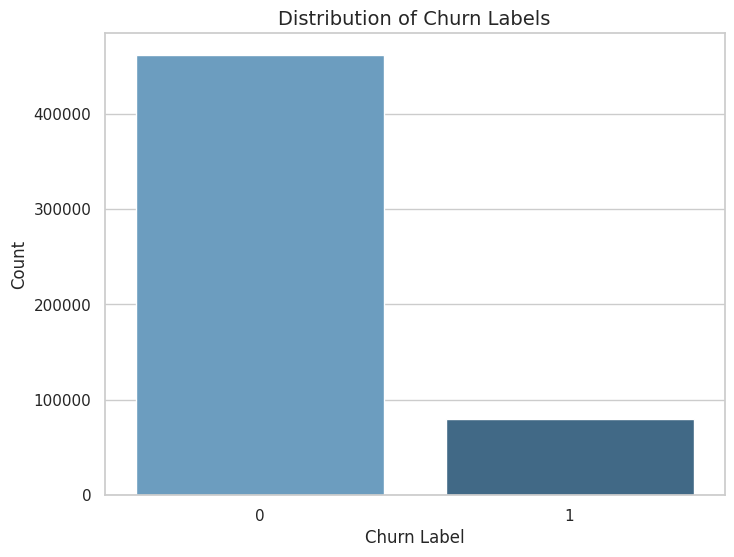

In [53]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='churn_label', y='count', data=churn_counts.toPandas(), palette='Blues_d')
plt.title("Distribution of Churn Labels", fontsize=14)
plt.xlabel("Churn Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

What this figure shows us that our after labeling our data, it has got imbalnced as there are 79810 churned records and 461232 records are not churned. If we train the model without handling this imbalanced behaviour of data, our model won't learn properly which can result in underfitting.
So here to handle imbalanced data i will apply smote analayis on it

In [57]:
X = df.toPandas().drop("churn_label", axis=1)  # Features
y = df.toPandas()['churn_label']  # Target (churn_label)

smote = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='churn_label')




ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pyspark/errors/exceptions/captured.py", line 179, in deco
    return f(*a, **kw)
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <exception str() failed>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^

ConnectionRefusedError: [Errno 111] Connection refused